In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from Final import quasi_newton, optimization


### Testing


In [2]:
# problem
def rosen(x):
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2


def rosen_grad(x):  # analytic grad for plotting ||∇f||
    dfdx = -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0])
    dfdy = 200 * (x[1] - x[0] ** 2)
    return np.array([dfdx, dfdy], dtype=float)


x0 = np.array([-0.5, 3.0], dtype=float)
op = optimization.OptimizationProblem(rosen)

methods: list[tuple[str, quasi_newton.QuasiNewtonBase]] = [
    ("Good Broyden", quasi_newton.GoodBroyden(op, ls_method="golden")),
    ("Bad Broyden", quasi_newton.BadBroyden(op, ls_method="golden")),
    ("SR1", quasi_newton.SymmetricBroydenSR1(op, ls_method="golden")),
    ("DFP", quasi_newton.DFP(op, ls_method="golden")),
    ("BFGS", quasi_newton.BFGS(op, ls_method="golden")),
]
results = {}
summary = []
for name, M in methods:
    steps = M.solve(x0, max_iter=20000)  # big cap for bad Broyden
    fx = np.array([rosen(s) for s in steps])
    gnorm = np.array([np.linalg.norm(rosen_grad(s)) for s in steps])
    results[name] = {"steps": steps, "fx": fx, "gnorm": gnorm}
    summary.append((name, len(steps) - 1, steps[-1], fx[-1], gnorm[-1]))

# pretty print summary
print(
    "Method              iters   final x                     f(x_final)         ||grad||"
)
for name, iters, xfin, ffin, gfin in summary:
    print(
        f"{name:16s} {iters:6d}   [{xfin[0]: .8f}, {xfin[1]: .8f}]   {ffin: .3e}   {gfin: .3e}"
    )

Method              iters   final x                     f(x_final)         ||grad||
Good Broyden        140   [ 1.00000000,  1.00000000]    3.634e-20    2.082e-10
Bad Broyden        6629   [ 0.99999890,  0.99999780]    1.207e-12    9.977e-07
SR1                  26   [ 0.99999993,  0.99999987]    4.555e-15    5.860e-07
DFP                  22   [ 1.00000000,  1.00000000]    2.103e-17    2.024e-07
BFGS                 22   [ 1.00000000,  1.00000000]    2.122e-17    2.027e-07


- Final x - Optimization paths on Rosenbrock: all methods ended extremely close to the true minimizer [1,1].
- f(x_final)- Objective value per iteration; Log-scale plot of f(x_k): objective value is ≈0 (tiny numbers → essentially machine precision).
- ||grad|| - Gradient norm per iteration on log scale: gradient norms are very small → confirms convergence. (measure of convergence to a stationary point.)


### Visualization


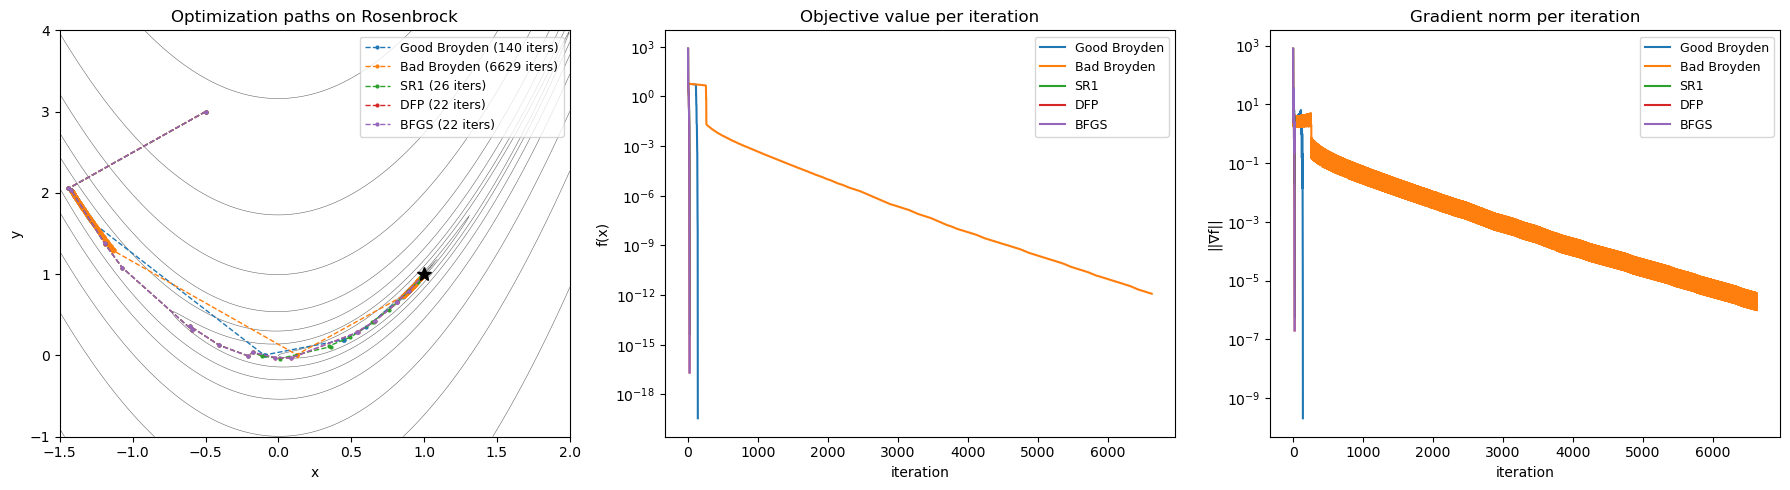

In [3]:
# background contours
xgrid = np.linspace(-1.5, 2.0, 500)
ygrid = np.linspace(-1.0, 4.0, 500)
X, Y = np.meshgrid(xgrid, ygrid)
Z = 100 * (Y - X**2) ** 2 + (1 - X) ** 2
levels = [1e-3, 1e-2, 1e-1, 1, 3, 10, 30, 100, 300, 1e3, 3e3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (A) Trajectories
ax = axes[0]
ax.contour(X, Y, Z, levels=levels, colors="black", linewidths=0.4, alpha=0.6)
palette = {
    "Good Broyden": "tab:blue",
    "Bad Broyden": "tab:orange",
    "SR1": "tab:green",
    "DFP": "tab:red",
    "BFGS": "tab:purple",
}
for name in palette:
    S = results[name]["steps"]
    ax.plot(
        S[:, 0],
        S[:, 1],
        marker="o",
        markersize=2,
        linewidth=1.0,
        linestyle="--",
        color=palette[name],
        label=f"{name} ({len(S) - 1} iters)",
    )
ax.plot(1, 1, "k*", markersize=10)
ax.set_title("Optimization paths on Rosenbrock")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc="upper right", fontsize=9)

# (B) f(x_k) vs iteration (log y)
ax = axes[1]
for name in palette:
    fx = results[name]["fx"]
    ax.semilogy(fx, label=name, linewidth=1.5)
ax.set_title("Objective value per iteration")
ax.set_xlabel("iteration")
ax.set_ylabel("f(x)")
ax.legend(fontsize=9)

# (C) ||grad|| vs iteration (log y)
ax = axes[2]
for name in palette:
    gnorm = results[name]["gnorm"]
    ax.semilogy(gnorm, label=name, linewidth=1.5)
ax.set_title("Gradient norm per iteration")
ax.set_xlabel("iteration")
ax.set_ylabel("||∇f||")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()